## Exploring and modifiying the Vasicek model

Disclaimer: 
<br> This solution is showcased to share my understanding of the problem and my own approach to it.
<br> This solution is not intended for any general application.

#### For questions, suggestions and further details, please feel free to contact me at juan-carlos.ramirez@warwick.ac.uk

---------

## Motivation

The aim of this project is to model the short-rate curve using the Vasicek model and the exponential Vasicek model, see the differences produced by the models in both rates and Zero Coupon Bond prices.

---

## Models
First, it is important to note that this models are not part of the HJM framework, for us that implies that we won't use market data to calibrate the model, this models will be fully defined by the parameters provided that the models have an Affine Term Structure (ATS), the models we are going to use are given below

### Classic Vasicek
A well known model which fulfills the ATS condition when using constant parameters, given as gollows

$$ dr_{t} = \big( \alpha - \beta r_{t} \big)dt + \sigma dW_{t}^{\mathbb{Q}} $$

Note: 
- $\alpha, \beta, \sigma$ are arbitrary parameters
- The definition of ATS and the proof ot his models having an ATS is out of the scope of this project.

### Exponential Vasicek / Ornstein-Uhlenbeck
This model is an extension of the Vasicek model, which comes from applying the transformation $r(t) = e^{y(t)}$ with $y(t)$ being the classic Vasicek model as presented above. Applying Ito's formula to find the dynamics of this transformation, we can find that, under the exponential Vasicek model

$$ \frac{dr_{t}}{r_{t}} = \big( \alpha + \frac{\sigma^{2}}{2} - \beta ln(r_{t}) \big)dt + \sigma dW_{t}^{\mathbb{Q}}$$

### Shifted Exponential Vasicek / Ornstein-Uhlenbeck
One of the main implications of the move from classic to exponential Vasicek is that the second will not generate negative interest rates, if such behavior is designed by the current modelling need, the model can be modified to allow negative rates by

$$ \tilde{r_{t}} = r_{t} - \zeta, \quad \zeta \, \epsilon \, \mathbb{R}^{+} $$

Using Ito's to find the new dynamics after applying this transformation gives us

$$ d\tilde{r_{t}} = r_{t} \, \big[ \big( \alpha + \frac{\sigma^{2}}{2} - \beta log(r_{t}) \big)dt + \sigma dW_{t}^{\mathbb{Q}} \big] = dr_{t}$$

which shows that the dynamics of the short-rate are not affected by the shift, only the solution is shifted, therefore the log-normal distribution of the Exponential Vasicek model holds.

----
## Implementation

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set_theme() # Seaborn template
sns.set_palette(palette="crest") # Default colors
plt.rcParams['figure.figsize'] = [12, 6] # Default to bigger plots

In [2]:
# Euler FTS Monte Carlo for a 1-dimensional brownian motion
def Vasicek_MonteCarlo(r, T, alpha, beta, sigma, zeta, Npaths):
    
    Nsteps = int(12 * T) # simulating every month
    
    Z = np.random.normal(0.0,1.0,[Npaths,Nsteps])
    r_V, r_EV = np.zeros([Npaths, Nsteps+1]), np.zeros([Npaths, Nsteps+1])
    P_V, P_EV, P_SEV = np.zeros([Npaths, Nsteps+1]), np.zeros([Npaths, Nsteps+1]), np.zeros([Npaths, Nsteps+1])
    
    # NOTE: EV and SEV needs to be transformed as we explained in the model description
    r_V[:,0], r_EV[:,0] = r, np.exp(r)
    P_V[:,0], P_EV[:,0], P_SEV[:,0] = 1.0, 1.0, 1.0
    
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    for i in range(0,Nsteps):
        # Making sure that samples from normal have mean 0 and variance 1
        if Npaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])

        # Simulate the classic Vasicek model
        r_V[:,i+1] = r_V[:,i] + (alpha - beta * r_V[:,i]) * dt + sigma * (dt**0.5)*Z[:,i]
        P_V[:,i+1] = P_V[:,i] * np.exp(-(r_V[:,i+1] + r_V[:,i]) * 0.5 * dt)
        
        # Simulate the exponential Vasicek model
        r_EV[:,i+1] = r_EV[:,i] * ( 1.0 + (alpha + sigma**2/2 - beta * np.log(r_EV[:,i])) * dt + sigma * (dt**0.5)*Z[:,i] )
        P_EV[:,i+1] = P_EV[:,i] * np.exp(-(np.log(r_EV[:,i+1]) + np.log(r_EV[:,i])) * 0.5 * dt)
        
        # Compute the ZCB prices with the shifted rates (as we saw in the model description, the dynamics are not affected)
        P_SEV[:,i+1] = P_SEV[:,i] * np.exp(-(np.log(r_EV[:,i+1] - zeta) + np.log(r_EV[:,i]) - zeta) * 0.5 * dt)
    
    # Remove transformation to make Exponential Vasicek go back to Classic Vasicek
    # r_EV = np.log(r_EV)
    
    return {'t':t, 'SR_V':r_V*100, 'SR_EV':r_EV*100, 'ZCB_V':P_V, 'ZCB_EV':P_EV, 'ZCB_SEV':P_SEV}

---- 
## Results

Next we generate the simulations using the function created in the above cells

In [3]:
r = 0.04 # Initial rate
T = 40.0 # Maximum tenor
alpha = 0.06 # "Long term mean"
beta = 0.10 # "Long term multiplier"
sigma = 0.05 # Volatility
zeta = 0.06 # Shift
Npaths = 1000 # Simulations

Results = Vasicek_MonteCarlo(r, T, alpha, beta, sigma, zeta, Npaths)
print('Plotting...')

Plotting...


In this plot, we can see that the actual shape of the simulations is similar, this is (in my opinion) consistent with the different distributions of the short-rates under this two models.

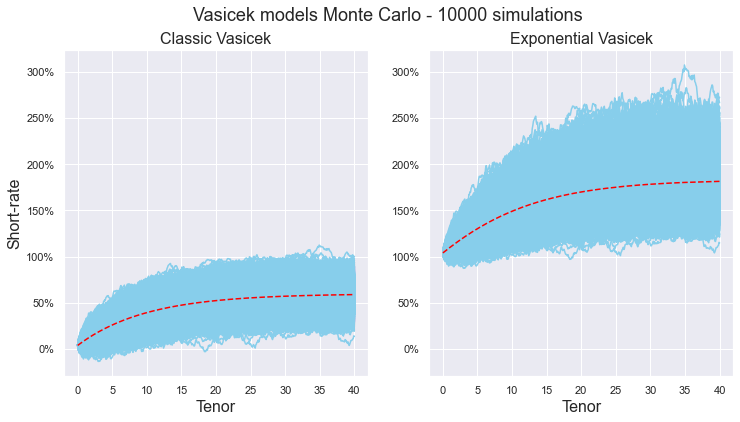

In [4]:
if Npaths <= 10000:
    SR_V = Results['SR_V']
    SR_EV = Results['SR_EV']

    fig = plt.figure()
    fig.suptitle('Vasicek models Monte Carlo - ' + str(Npaths) + ' simulations' ,fontsize=18)
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    ax1.set_title('Classic Vasicek',fontsize=16)
    ax1.plot(Results['t'], np.transpose(SR_V), 'skyblue')
    ax1.plot(Results['t'], np.transpose(SR_V).mean(axis=1), '--', color='red')
    ax1.set_ylabel("Short-rate", fontsize=16)
    ax1.set_xlabel("Tenor", fontsize=16)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax2.set_title('Exponential Vasicek',fontsize=16)
    ax2.plot(Results['t'], np.transpose(SR_EV), 'skyblue')
    ax2.plot(Results['t'], np.transpose(SR_EV).mean(axis=1), '--', color='red')
    ax2.set_xlabel("Tenor", fontsize=16)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax1.get_shared_y_axes().join(ax1, ax2)
    plt.subplots_adjust(hspace=0.01)
    ax2.autoscale()
    plt.show()
else:
    print('Monte Carlo paths plots skipped, input at most 10,000 simulations to show')

Next, we compute simulations for the ZCB prices given the short-rates above, we do this to be able to compare with our next plot

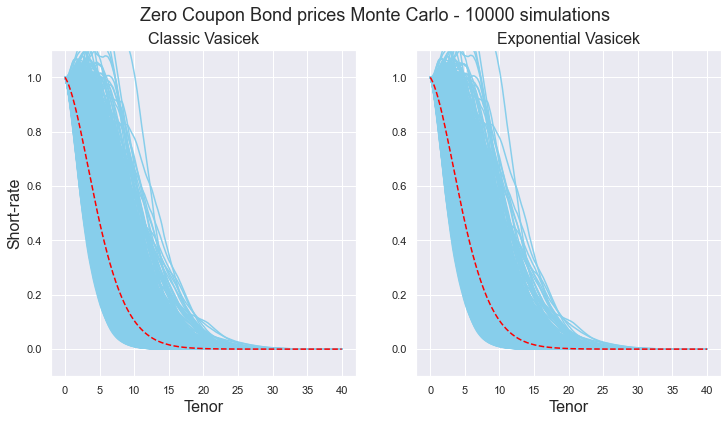

In [5]:
if Npaths <= 10000:
    ZCB_V = Results['ZCB_V']
    ZCB_EV = Results['ZCB_EV']

    fig = plt.figure()
    fig.suptitle('Zero Coupon Bond prices Monte Carlo - ' + str(Npaths) + ' simulations' ,fontsize=18)
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    ax1.set_title('Classic Vasicek',fontsize=16)
    ax1.plot(Results['t'], np.transpose(ZCB_V), 'skyblue')
    ax1.plot(Results['t'], np.transpose(ZCB_V).mean(axis=1), '--', color='red')
    ax1.set_ylabel("Short-rate", fontsize=16)
    ax1.set_xlabel("Tenor", fontsize=16)
    ax1.set_ylim([-0.10, 1.10])

    ax2.set_title('Exponential Vasicek',fontsize=16)
    ax2.plot(Results['t'], np.transpose(ZCB_EV), 'skyblue')
    ax2.plot(Results['t'], np.transpose(ZCB_EV).mean(axis=1), '--', color='red')
    ax2.set_xlabel("Tenor", fontsize=16)
    ax2.set_ylim([-0.10, 1.10])

    ax1.get_shared_y_axes().join(ax1, ax2)
    plt.subplots_adjust(hspace=0.01)
    ax2.autoscale()
    plt.show()
else:
    print('Monte Carlo paths plots skipped, input at most 10,000 simulations to show')

Here we compare the effect of shifting the short-rates from the Exponential Vasicek model, the only apparent change here seems to be an increase in the volatilty of the simulations.

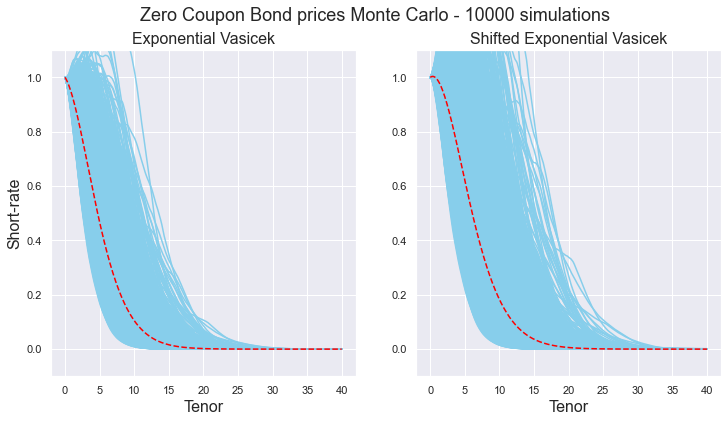

In [6]:
if Npaths <= 10000:
    ZCB_EV = Results['ZCB_EV']
    ZCB_SEV = Results['ZCB_SEV']

    fig = plt.figure()
    fig.suptitle('Zero Coupon Bond prices Monte Carlo - ' + str(Npaths) + ' simulations' ,fontsize=18)
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    ax1.set_title('Exponential Vasicek',fontsize=16)
    ax1.plot(Results['t'], np.transpose(ZCB_EV), 'skyblue')
    ax1.plot(Results['t'], np.transpose(ZCB_EV).mean(axis=1), '--', color='red')
    ax1.set_ylabel("Short-rate", fontsize=16)
    ax1.set_xlabel("Tenor", fontsize=16)
    ax1.set_ylim([-0.10, 1.10])

    ax2.set_title('Shifted Exponential Vasicek',fontsize=16)
    ax2.plot(Results['t'], np.transpose(ZCB_SEV), 'skyblue')
    ax2.plot(Results['t'], np.transpose(ZCB_SEV).mean(axis=1), '--', color='red')
    ax2.set_xlabel("Tenor", fontsize=16)
    ax2.set_ylim([-0.10, 1.10])

    ax1.get_shared_y_axes().join(ax1, ax2)
    plt.subplots_adjust(hspace=0.01)
    ax2.autoscale()
    plt.show()
else:
    print('Monte Carlo paths plots skipped, input at most 10,000 simulations to show')

It is important to note that the parameters used for the simulations are completely arbitrary for this exercise, a more realistic excercise would require us to calibrate the model using historical market data (using techniques such  as Moment matching or Ordinary least squares), we can see here why the HJM framework can be considered a more powerful approach, since it already considers market data to calibrate itself during the modeling process.

---- 
## References

This code is based on the excellent material provided at

“Mathematical Modeling and Computation
in Finance: With Exercises and Python and MATLAB Computer Codes”,
by C.W. Oosterlee and L.A. Grzelak, World Scientific Publishing Europe Ltd, 2019.